# KELM with PCA

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from TfELM.Resources.Kernel import Kernel, CombinedProductKernel, CombinedSumKernel
from TfELM.Layers.KELMLayer import KELMLayer
from TfELM.Models.KELMModel import KELMModel

from alzheption.utils import custom_cross_val_score
from alzheption.clahe import Clahe
from alzheption.extractor import AlzheptionExtractor
from alzheption.classificator import AlzheptionClassificator

2025-03-02 13:43:12.915894: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-02 13:43:12.930342: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740897792.947280  634882 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740897792.952363  634882 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 13:43:12.969814: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
alex_1 = AlzheptionExtractor.load_extractor("../../asset/AlzheptionExtractor.pkl", path_dataset_new="../../asset/dataset_jpg_brightness/")

alex_1.train_features.__len__(), alex_1.test_features.__len__()

(3532, 883)

In [3]:
alex_1.dataset

Dataset ImageFolder
    Number of datapoints: 4415
    Root location: ../../asset/dataset_jpg_brightness/

In [4]:
alex_1.dataset[0]

(<PIL.Image.Image image mode=RGB size=256x256>, 0)

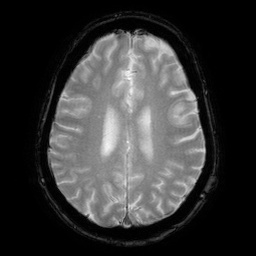

In [5]:
alex_1.dataset[0][0]

In [6]:
alex_1.view_train_label_distribution()

,label,count
0,0,501
1,1,910
2,2,1159
3,3,632
4,4,76
5,5,254


In [7]:
alex_1.view_test_label_distribution()

,label,count
0,0,129
1,1,235
2,2,266
3,3,178
4,4,19
5,5,56


In [8]:
alex_1.balance_feature()

In [9]:
alex_1.view_train_label_distribution()

,label,count
0,0,76
1,1,76
2,2,76
3,3,76
4,4,76
5,5,76


In [10]:
alex_1.view_test_label_distribution()

,label,count
0,0,19
1,1,19
2,2,19
3,3,19
4,4,19
5,5,19


In [11]:
pca = PCA(n_components=min(100, *alex_1.train_features.shape))
train_features = pca.fit_transform(alex_1.train_features)
test_features = pca.transform(alex_1.test_features)

train_features.shape, alex_1.train_labels.__len__()

((456, 100), 456)

In [12]:
list_kernel = [
    Kernel("rbf"),
    Kernel("laplacian"),
    Kernel("sigmoid"),
    Kernel("exponential"),
    Kernel("cosine"),
    Kernel("morlet_wavelet"),
    Kernel("mexican_hat_wavelet"),
    Kernel("haar_wavelet"),
    Kernel("rational_quadratic"),
]

list_activation = [
    "identity",
    "sigmoid",
    "tanh",
    "relu",
    "leaky_relu",
    "prelu",
    "elu",
    "softplus",
    "bent_identity",
    "gaussian",
    "sinusoidal",
    "isru",
    "isrlu",
    "selu",
    "softmax",
    "ssigmoid",
    "silu",
    "gelu",
    "log",
    "cube",
    "inverse",
    "swish",
    "mish",
    "bis",
    "gompertz",
    "elliott",
    "isq",
    "hardshrink",
    "softshrink",
    "sqrelu",
    "sine",
    "softexp",
    "arctan",
    "sin_transfer",
    "hsigmoid",
    "tsigmoid",
    "arcsinh",
    "logit",
    "tlu",
    "aq",
    "logsigmoid",
    "cosine",
    "relu_cos",
    "imq",
    "cos_sigmoid",
    "triangular",
    "hardtanh",
    "inverse_sine",
    "bezier",
    "bsigmoid",
    "power",
    "gswish",
    "invgamma",
    "softclip",
    "inverse_cosine",
    "sinusoid",
    "inv_logit",
    "soft_exponential",
    "srelu",
    "inverse_tangent",
    "hswish",
    "aqrelu",
    "gelu2",
    "sinusoid2",
    "inverse_tanh",
    "leaky_softplus",
    "gaussian_tangent",
    "exp_cosine",
    "gaussian_cdf",
    "hmish",
    "smooth_sigmoid",
    "log_exp",
    "cubic",
    "exp_sine",
    "sym_sigmoid",
    "square",
    "soft_clipping",
    "swish_gaussian",
    "hard_shrink",
    "smooth_hard_tanh",
    "bipolar_sigmoid",
    "log_sigmoid",
    "hard_sigmoid",
    "invsqrt",
    "gauss_tanh",
    "egaulu",
    "logarithm",
    "inv_sine",
    "hard_tanh",
    "bent_identity_smoothed",
    "pos_softplus",
    "inv_multiquadratic",
    "inv_cosine",
    "asymmetric_gaussian",
    "inv_quadratic",
    "gaussian_squared",
    "symmetric_sigmoid",
    "inv_cubic",
    "cauchy",
    "exponential_quadratic",
    "rational_quadratic",
    "cubic_spline",
    "symmetric_soft_clipping",
    "binary_step",
    "imrbf",
    "cloglog",
    "nrelu",
]

list_layer = [
    {
        "kernel_name": kernel.kernel_name,
        "kernel_param": kernel.kernel_param,
        "activation_name": activation,
        "layer": KELMLayer(kernel, activation)
    } for kernel in list_kernel for activation in list_activation
]

list_model = [
    {
        **layer,
        "model": KELMModel(layer.get("layer")),
    } for layer in list_layer
]

len(list_model)

963

In [13]:
list_model[-7]

{'kernel_name': 'rational_quadratic',
 'kernel_param': 1.0,
 'activation_name': 'rational_quadratic',
 'layer': <TfELM.Layers.KELMLayer.KELMLayer at 0x7eb8822ba1e0>,
 'model': KELMModel(kelm=<TfELM.Layers.KELMLayer.KELMLayer object at 0x7eb8822ba1e0>)}

In [14]:
# Cross Validation Param:
n_splits = 5
n_repeats = 5

In [15]:
alcl = AlzheptionClassificator(alex_1, list_model, n_splits=n_splits, n_repeats=n_repeats)

In [16]:
data = alcl.evaluate_with_cross_validation(n_components=100)

Score: 0: 100%|██████████| 963/963 [18:33<00:00,  1.16s/it]

            kernel_name  kernel_param          activation_name  \
0                   rbf           1.0                 identity   
1                   rbf           1.0                  sigmoid   
2                   rbf           1.0                     tanh   
3                   rbf           1.0                     relu   
4                   rbf           1.0               leaky_relu   
..                  ...           ...                      ...   
958  rational_quadratic           1.0  symmetric_soft_clipping   
959  rational_quadratic           1.0              binary_step   
960  rational_quadratic           1.0                    imrbf   
961  rational_quadratic           1.0                  cloglog   
962  rational_quadratic           1.0                    nrelu   

                                            score_list  score_mean  
0    [0.3684210526315789, 0.38596491228070173, 0.35...    0.369825  
1    [0.3684210526315789, 0.38596491228070173, 0.35...    0.369825  


In [23]:
alcl.df_evaluation.to_parquet("result/TrainKELM.parquet", index=False)

In [17]:
# # Train KELM on the extracted training features
# kelm_model.fit(train_features, alex_1.train_labels)

In [18]:
# # Evaluate the KELM model on the test set
# predictions = kelm_model.predict(train_features).numpy()
# accuracy = accuracy_score(predictions, alex_1.train_labels)
# print(f"Test Accuracy: {accuracy:.4f}")

In [19]:
# # Evaluate the KELM model on the test set
# predictions = kelm_model.predict(test_features).numpy()
# accuracy = accuracy_score(predictions, alex_1.test_labels)
# print(f"Test Accuracy: {accuracy:.4f}")